# $p_T$ and Biscuits

A notebook to select a 4th b-jet by sorting events by $p_T$ and picking the highest non-b-tagged jet.

In [1]:
import uproot as ur
import uproot_methods as urm
import numpy as np
import awkward
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences

import tools
filename = "user.jagrundy.20736236._000001.MiniNTuple.root"

Using TensorFlow backend.


Load ntuple, get the data we need from the file

In [2]:
s_table = tools.open_file(filename, sort_by="pt")

sorting data by pt


Filters

In [3]:
nj4 = s_table.njets>=4   # >=4 jets exist
nb4 = s_table.nbjets>=4  # >=4 b jets really exist
nt3 = s_table.nbtags==3  # 3 b tags
nb4nt3 = nb4 & nt3

# I assume this is the real condition, right?
# where we have >=4 jets, exactly 3 of which are tagged
nj4nt3 = nj4 & nt3

# filter the s_table
events = s_table[nj4nt3]
n_events = len(events)
print("n_events =", n_events)

n_events = 312386


graph jet $p_T$ with whichever filter we wanted

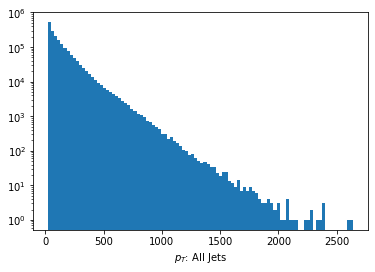

In [4]:
pt = events.resolved_lv.pt.flatten()
plt.hist(pt, bins=100)
plt.yscale('log')
plt.xlabel("$p_T$: All Jets")
plt.show()

then plot the $n$-th jet's $p_T$ for each $n$

I wanted to do this with n where not every event had n jets, but instead I settled for just doing the first 4.

How would you edit this to get the other jets? Padding with zeros, or is there a better way?



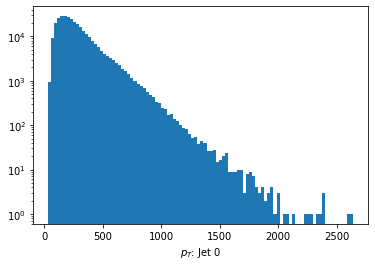

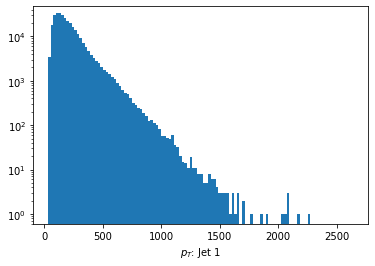

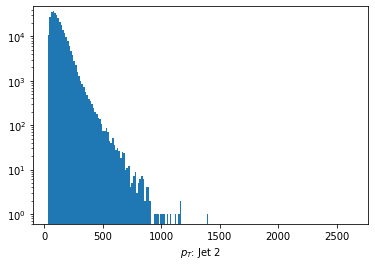

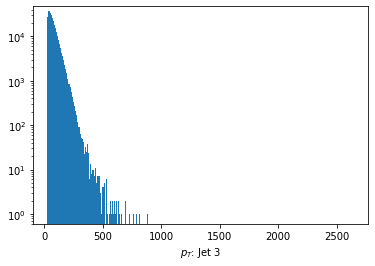

In [5]:
# it's interesting to compare the different jets using the same xlim, ylim
# so set xlim, ylim using the n=0 data
fig, ax = plt.subplots()
xmin, xmax, ymin, ymax = None, None, None, None
for n in range(4):
    # graph jet pt with whichever filter we wanted
    nth_pt = events.resolved_lv.pt[:,n]
    plt.hist(nth_pt, bins=100)
    plt.yscale('log')
    if n == 0:
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
    else:
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
    plt.xlabel(f"$p_T$: Jet {n}")
    plt.show()

I guess the next step is to pick the missing 4th jet given the 3 tags, just based on $p_T$

In [6]:
# for the 4th jet, pick the first non-b-tagged jet (since they're sorted by pt)

pt = events["resolved_lv"].pt
tag = events['tag']
truth = events['truth']

# pad these
truth = pad_sequences(truth,padding='post')
tag = pad_sequences(tag, padding='post')

# insert a way to decide if we should tag a 4th or not
# for now just always pick a 4th
tag_a_fourth = np.ones(len(pt))

# actually make the choices
choice = np.zeros(tag.shape, dtype=int)
for i in range(len(tag)):
    # if we decide to tag a 4th jet, do this
    if tag_a_fourth[i]:
        # take the first (sorted wrt pt) non-tagged jet
        fourth_index = np.where(tag[i] == 0)[0][0]
        # "choose" that jet
        choice[i][fourth_index] = 1

Evaluate this model

In [7]:
import importlib
importlib.reload(tools)
tools.evaluate_model(truth, tag, choice)

100%|██████████| 312386/312386 [00:02<00:00, 106366.28it/s]

    Total number of events: 312386
    Minus events ignored: 8204, (2.63%)

    4th b-jet really exists:
        Correct 4th jet picked:         63.36%, 109232
        Incorrect 4th jet picked:       36.64%, 63159
        Event incorrectly ignored:      0.00%, 0

    No 4th b-jet really exists:
        Correctly ignored event:        0.00%, 0
        Incorrectly picked a 4th jet:   100.00%, 131791

    Or formatted in table form:
                    ____________________
                   |Truth-Matching      |
                   |____________________|
                   |4th exists  |No 4th |
     ______________|____________|_______|
    |4th |4th found|corr. 063.4%| 100.0%|
    |Jet |         |inco. 036.6%|       |
    |Reco|_________|____________|_______|
    |    |no 4th   |      000.0%| 000.0%|
    |____|_________|____________|_______|

    (columns add to 100% each)
    

